In [10]:
import tensorflow as tf 
import numpy as np 
from matplotlib import pyplot as plt 
import cPickle
from sklearn import model_selection
from tqdm import tqdm

In [11]:
def get_cifar_data(cifar_data_location):
    def unpickle( file ):
        fo = open(file, 'rb')
        dict = cPickle.load(fo)
        fo.close()
        return dict

    data = unpickle( cifar_data_location )

    features = data['data']
    labels = data['labels']
    labels = np.atleast_2d( labels ).T

    return labels, features

In [52]:
def conv( x, filter_size=3, stride=2, num_filters=128, is_output=False, name="conv" ):
    '''
    x is an input tensor
    Declare a name scope using the "name" parameter
    Within that scope:
      Create a W filter variable with the proper size
      Create a B bias variable with the proper size
      Convolve x with W by calling the tf.nn.conv2d function
      Add the bias
      If is_output is False,
        Call the tf.nn.relu function
      Return the final op
    ''' 
    x_shape = x.get_shape().as_list()

    with tf.name_scope(name) as scope:
        W = tf.get_variable(name='W_{}'.format(name), shape=[filter_size, filter_size, x_shape[-1], num_filters], initializer=tf.contrib.layers.variance_scaling_initializer())
        b = tf.get_variable(name='b_{}'.format(name), shape=[num_filters], initializer=tf.contrib.layers.variance_scaling_initializer())

        convolution = tf.nn.conv2d(input=x, filter=W, strides=[1,stride, stride,1], padding='SAME', use_cudnn_on_gpu=None, data_format=None, name=None)
        convolution = convolution + b

        if is_output == 'False':
            activated_output = tf.nn.relu(features=convolution, name=None)
            return activated_output #This actually returns the whole computation graph that makes this.
  
        return convolution

In [53]:
def fc( x, out_size=150, is_output='False', name="fc" ): #Bigger outsize makes it converge higher, but slower.
    '''
    x is an input tensor
    Declare a name scope using the "name" parameter
    Within that scope:
    Create a W filter variable with the proper size
    Create a B bias variable with the proper size
    Multiply x by W and add b
    If is_output is False,
    Call the tf.nn.relu function
    Return the final op
    '''
    x_shape = x.get_shape().as_list()

    with tf.name_scope(name) as scope:
        W = tf.get_variable(name='W_{}'.format(name), shape=[x_shape[-1], out_size], initializer=tf.contrib.layers.variance_scaling_initializer())
        b = tf.get_variable(name='b_{}'.format(name), shape=[out_size], initializer=tf.contrib.layers.variance_scaling_initializer())

        h = tf.matmul(x,W) + b

        if is_output == 'False':
            activated_output = tf.nn.relu(features=h, name=None)
            return activated_output

        return h

In [55]:
#10 epochs is enough to get it over the minimum requirement of 20% accuracy, but 
#if you bump it up to 20 epochs, we can approach 50% accuracy.
num_epochs = 50


#Create DNN
with tf.Graph().as_default():
    #PLAYERS
    x = tf.placeholder(tf.float32, shape=[1, 32, 32, 3], name='features') #Number parameters
    y_ = tf.placeholder(tf.int64, shape=[1], name='labels') #Number labels.
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    
    #GAME
    h_conv1 = conv(x, name='conv1')
    h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


    h_conv2 = conv(h_pool1, name='conv2')
    h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    h_pool2_drop = tf.nn.dropout(h_pool1, keep_prob)
    
    h_conv3 = conv(h_pool2_drop, name='conv3')
    h_pool3 = tf.nn.max_pool(h_conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    h_conv4 = conv(h_pool3, name='conv4')
    h_pool4 = tf.nn.max_pool(h_conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    h_pool4_flat = tf.reshape(h_pool4, [-1, 128])

    fc_1 = fc(h_pool4_flat, name='fc1')
    fc_1_drop = tf.nn.dropout(fc_1, keep_prob)
    
    fc_2 = fc(fc_1_drop, name='fc2')
    
    fc_3 = fc(fc_2, name='fc3')
    
    fc_4 = fc(fc_3, name='fc4')
    
    fc_5 = fc(fc_4, name='fc5')
    
    fc_6 = fc(fc_5, name='fc6')

    logits = fc(fc_6, out_size=10, is_output='True', name='fc7')
    y_guess = tf.argmax(logits, axis=1)

    cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_, logits=logits))

    #TRAIN
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    correct_prediction = tf.equal(y_guess, y_)
    accuracy = tf.cast(correct_prediction, tf.float32)

    #DATA
    cifar_labels, cifar_features = get_cifar_data('cifar-10-batches-py/data_batch_3') #just 1 batch.
    cifar_features_whitened = (cifar_features - np.mean(cifar_features)) / np.std(cifar_features)
    cifar_features_whitened = cifar_features_whitened.reshape([len(cifar_features_whitened), 1, 32, 32, 3])
    x_train, x_test, y_train, y_test = model_selection.train_test_split(cifar_features_whitened, cifar_labels, test_size=0.2)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        all_test_accuracies, all_train_accuracies = [], []

        for _ in tqdm(xrange(num_epochs)):
            this_iter_test_accuracy, this_iter_train_accuracy = [], []

            for train_ind, train_image in enumerate(x_train):
                train_accuracy, _ = sess.run([accuracy, train_step], feed_dict={x:train_image, y_:y_train[train_ind], keep_prob:0.5}) 
                this_iter_train_accuracy.append(train_accuracy)

            for test_ind, test_image in enumerate(x_test):
                test_accuracy = sess.run([accuracy], feed_dict={x:test_image, y_:y_test[test_ind], keep_prob:1.0}) #When we test it, we want to keep the whole network.
                this_iter_test_accuracy.append(test_accuracy)

            all_test_accuracies.append(np.mean(this_iter_test_accuracy))
            all_train_accuracies.append(np.mean(this_iter_train_accuracy))

        writer = tf.summary.FileWriter("image_classifier_graph", sess.graph)

writer.close()

100%|██████████| 50/50 [50:45<00:00, 68.55s/it]


True

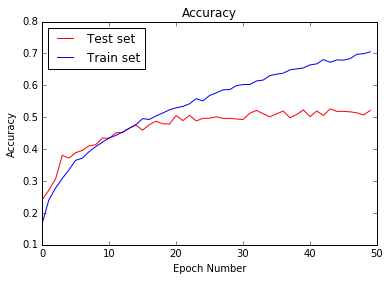

In [57]:
plt.plot(all_test_accuracies, 'r', label='Test set')
plt.plot(all_train_accuracies, 'b', label='Train set')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='upper left')
plt.show()